# Earth

In [0]:
!pip install -U -q netcdf4 xarray pytype google-cloud-storage pyresample

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from typing import Any, Callable, Dict, List, Optional, Text, Tuple, Union

import collections
from contextlib import contextmanager
import datetime
import dateutil.tz
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pyresample
import re
import skimage 
import skimage.transform
import tempfile
import tensorflow as tf
from tensorflow import keras
import time
import urllib
import xarray

import google.cloud.storage as gcs

from google.colab import auth
auth.authenticate_user()

PROJECT_ID = 'weather-324'
GOES_BUCKET = 'gcp-public-data-goes-16'
UTC = dateutil.tz.tzutc()

# https://visibleearth.nasa.gov/view.php?id=73909
BLUE_MARBLE = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x21600x10800.png'
BLUE_MARBLE = 'https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73909/world.topo.bathy.200412.3x5400x2700.jpg'

# Metadata fields to save from each imager file.
METADATA_KEYS = [
    'x',
    'y',
    'kappa0',
    'band_id',
    'x_image_bounds',
    'y_image_bounds',
    'goes_imager_projection',
    'time_coverage_start',
]

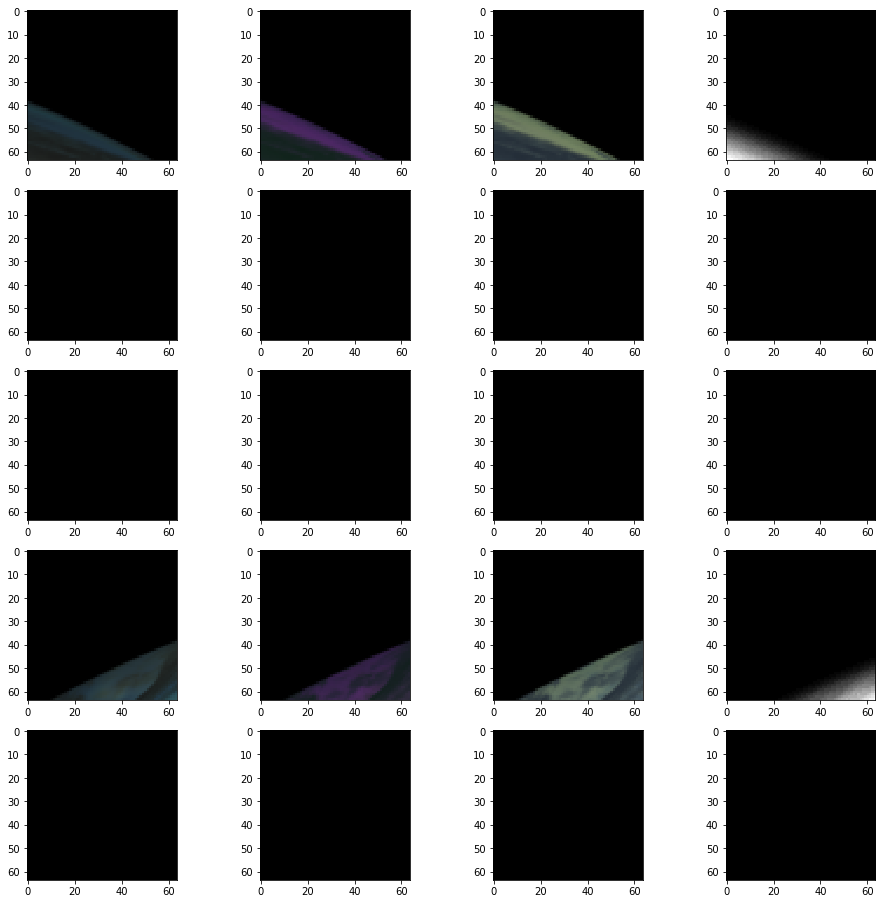

In [3]:
MAX_COLOR_VALUE = 255.9

CLOUD_MASK_FEATURE_NAME = 'cloud-mask'
IR_CHANNELS_FEATURE_NAME = 'ir-channels'

TRAIN_PATH = 'gs://weather-datasets/goes_truecolor/examples/train.tfrecord*'
TEST_PATH = 'gs://weather-datasets/goes_truecolor/examples/test.tfrecord*'

def make_dataset(
    pattern: Text,
    tile_size: int = 64,
    batch_size: int = 8,
    num_map_threads: int = 16,
    mode: tf.estimator.ModeKeys = tf.estimator.ModeKeys.TRAIN) -> tf.data.Dataset:
  """Create a dataset.
  
  Args:
    pattern: file input pattern.
    tile_size: size of the input tiles.
    
  Returns:
    A tf.data.Dataset
  """
  example_fmt = {
      CLOUD_MASK_FEATURE_NAME: tf.FixedLenFeature(
        (tile_size, tile_size, 1), tf.int64),
      IR_CHANNELS_FEATURE_NAME: tf.FixedLenFeature(
        (tile_size, tile_size, 9), tf.int64),
  }

  def parse_fn(example: Text) -> Tuple[Dict[Text, tf.Tensor], tf.Tensor]:
    parsed = tf.parse_single_example(example, example_fmt)
    raster_in_img = parsed[IR_CHANNELS_FEATURE_NAME]
    raster_out_img = parsed[CLOUD_MASK_FEATURE_NAME]
    raster_in_img = tf.cast(raster_in_img, tf.float32) / 256
    raster_out_img = tf.cast(raster_out_img, tf.float32) / 256
    return raster_in_img, raster_out_img

  is_training = mode == tf.estimator.ModeKeys.TRAIN
  ds = tf.data.Dataset.list_files(pattern, shuffle=is_training)
  ds = ds.repeat()
  ds = ds.interleave(tf.data.TFRecordDataset, cycle_length=4, num_parallel_calls=4)
  ds = ds.shuffle(batch_size * 16)
  ds = ds.map(map_func=parse_fn, num_parallel_calls=num_map_threads)
  ds = ds.batch(batch_size, drop_remainder=True)
  ds = ds.prefetch(32)
  return ds

def print_dataset(pattern):
  ds = make_dataset(pattern)  
  next = ds.make_one_shot_iterator().get_next()
  
  plt.figure(figsize=(16, 16))
  with tf.Session() as sess:
    sess = tf.Session()
    raster_in_img, raster_out_img = sess.run(next)
    raster_in_img = (raster_in_img[0:5, :, :, :] * MAX_COLOR_VALUE).astype(np.uint8)
    raster_out_img = (raster_out_img * MAX_COLOR_VALUE).astype(np.uint8)
    for i in range(5):
      for j in range(3):
        ax = plt.subplot(5, 4, i * 4 + j + 1)
        ax.imshow(raster_in_img[i, :, :, j*3:(j+1)*3])
      ax = plt.subplot(5, 4, i * 4 + 4)
      ax.imshow(raster_out_img[i, :, :, 0], cmap='gray')
  plt.show()
    
print_dataset(TRAIN_PATH)  

In [4]:
def default_hparams(**kwargs: Any) -> tf.contrib.training.HParams:
  """Create default hyper-parameters for training a model.

  Args:
    **kwargs: default hyper-parameter values to override.

  Returns:
    HParams object with all hyperparameter values.
  """
  hparams = tf.contrib.training.HParams(
      model_dir='',
      train_data_path=TRAIN_PATH,
      eval_data_path=TEST_PATH,
      train_batch_size=32,
      learning_rate=1e-3,
      train_steps=10000,
      num_eval_records=128,
      num_cores=8,
      tile_size=64,
      
      # CNN
      kernel_size=5,
      num_filters=16,
      num_layers=3,
  )
  hparams.override_from_dict(kwargs)
  return hparams

hparams = default_hparams()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
def export_keras(model: keras.Model, trained_model: keras.Model, output_dir: Text, hparams: tf.contrib.training.HParams):
  # Describe the input.
  tile_size = hparams.tile_size
  json_input = [keras.layers.Input(name='ref', dtype=tf.uint8, shape=(tile_size * tile_size))]

  # Reshape as image, which is what the model expects
  img = keras.layers.Reshape((tile_size, tile_size, 9))(json_input)

  # Use trained model to predict
  model_core = model
  model_core.set_weights(trained_model.get_weights())
  model_output = model_core(img)

  # Create serving model
  serving_model = keras.Model(json_input, model_output)

  # Save it
  export_path = tf.contrib.saved_model.save_keras_model(
      serving_model, os.path.join(hparams.model_dir, 'export/exporter'))
  export_path = export_path.decode('utf-8')
  tf.logging.info('Model exported successfully to %s', export_path)

def create_model(hparams: tf.contrib.training.HParams, img: tf.Tensor) -> tf.Tensor:
  kernel_size = hparams.kernel_size
  num_filters = hparams.num_filters
  num_layers = hparams.num_layers
  cnn = keras.layers.BatchNormalization()(img)
  for layer in range(num_layers):
    cnn = keras.layers.Conv2D(num_filters, (kernel_size, kernel_size), padding='same')(cnn)
    cnn = keras.layers.Activation('elu')(cnn)
    cnn = keras.layers.BatchNormalization()(cnn)
  cnn = keras.layers.Conv2D(1, (kernel_size, kernel_size), padding='same')(cnn)
  cnn = keras.layers.Activation('relu')(cnn)
  return cnn

def train_and_evaluate(hparams: tf.contrib.training.HParams) -> keras.Model:
  model_dir = hparams.model_dir
  max_steps = hparams.train_steps
  
  # Limit the epoch size.
  steps_per_epoch = min(1000, max_steps // 10)
  num_epochs = max(1, max_steps // steps_per_epoch)
  
  # eval batch size has to be divisible by num_cores
  eval_batch_size = min(hparams.num_eval_records, hparams.train_batch_size)
  eval_batch_size = eval_batch_size - eval_batch_size % hparams.num_cores
  eval_steps = hparams.num_eval_records // eval_batch_size
  tf.logging.info('train_batch_size=%d  eval_batch_size=%d train_steps=%d (%d x %d) eval_steps=%d',
                  hparams.train_batch_size, eval_batch_size,
                  max_steps, steps_per_epoch, num_epochs,
                  eval_steps)
  
  # Build the model
  input_img = keras.Input(shape=(hparams.tile_size, hparams.tile_size, 9))
  cnn = create_model(hparams, input_img)
  model = keras.Model(input_img, cnn)
  optimizer = tf.keras.optimizers.Adam(lr=hparams.learning_rate, clipnorm=1.)
  model.compile(optimizer=optimizer,
                loss=keras.losses.mean_absolute_error,
                metrics=['accuracy', 'mse'])

  # Make the datasets
  train_ds = make_dataset(
      hparams.train_data_path,
      mode=tf.estimator.ModeKeys.TRAIN,
      batch_size=hparams.train_batch_size)
  eval_ds = make_dataset(
      hparams.eval_data_path,
      mode=tf.estimator.ModeKeys.EVAL,
      batch_size=eval_batch_size)
  
  # train and evaluate
  start_timestamp = time.time()
  history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=eval_ds,
    validation_steps=eval_steps,
    verbose=2 # 1=progress 2=one line per epoch
  )
  elapsed_time = int(time.time() - start_timestamp)
  tf.logging.info('Finished training up to step %d. Elapsed seconds %d.',
                  max_steps, elapsed_time)
  tf.logging.info(model.summary())
  print("if running interactively, graph: {}".format(history.history.keys()))
  
  return model

model = train_and_evaluate(hparams)

INFO:tensorflow:train_batch_size=32  eval_batch_size=32 train_steps=10000 (1000 x 10) eval_steps=4
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
